# Linear fit of Bouguer lines on  Pic Du Midi Data


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in
https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/convertSpectraToPandas.py


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 28th 2020
- update : September 28th 2020 : 



# Import

In [78]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [79]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [80]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [81]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [82]:
from scipy import interpolate

# Functions

In [83]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [84]:
def GetSpectra(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
      
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [85]:
def GetSpectraFiltered(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>160 and idx<200:
            idx+=1
            continue
        if idx>220 and idx<226:
            idx+=1
            continue
        if idx>275 and idx<295:
        #if idx>260 and idx<295:
            idx+=1
            continue
            
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [86]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        mag_table[idx,:] = fcn(WL) 
        airm_table[idx]  = df.airmass[0]
        time_table[idx]  = df.time[0]
        
    return WL, mag_table, airm_table,time_table
       

In [87]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs time")
        plt.show()
     
    return 
     

In [88]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [89]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [90]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-28 14:03:44,851 MacBook-Pro-de-admin.local __main__[25763] INFO LA time:05:03:44
2020-09-28 14:03:44,854 MacBook-Pro-de-admin.local __main__[25763] INFO NY time:08:03:44
2020-09-28 14:03:44,855 MacBook-Pro-de-admin.local __main__[25763] INFO London time:13:03:44
2020-09-28 14:03:44,857 MacBook-Pro-de-admin.local __main__[25763] INFO Paris time:14:03:44
2020-09-28 14:03:44,858 MacBook-Pro-de-admin.local __main__[25763] INFO ************************ START *********************


In [91]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [92]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-28 14:03:44,871 MacBook-Pro-de-admin.local __main__[25763] INFO Configuration file : config/default.ini


In [93]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-09-28 14:03:44,878 MacBook-Pro-de-admin.local __main__[25763] INFO 1) Configuration


In [94]:
config_section = config.sections()

In [95]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [96]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [97]:
msg=f" Object observed {target}"
logger.info(msg)

2020-09-28 14:03:44,907 MacBook-Pro-de-admin.local __main__[25763] INFO  Object observed HD116405


In [98]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# input files

## sed

In [99]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [100]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [101]:
sed_m=-2.5*np.log10(sed_f)

## spectrum data

In [102]:
all_files = os.listdir(inputdir)
sorted_files=sorted(all_files)

In [103]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [104]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

In [105]:
NBFILES=len(selected_files)

In [106]:
msg=f" Number of selected files is {NBFILES}"
logger.info(msg)

2020-09-28 14:03:45,039 MacBook-Pro-de-admin.local __main__[25763] INFO  Number of selected files is 347


In [107]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

### Read all files

In [108]:
all_df=GetSpectra(inputdir,selected_files,normalisation_factor=normalisation_factor)

In [154]:
all_df[0].head()

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs
0,0,1.545961,0.0,380.067586,1.906583e-13,4.487186e-15,31.799361,0.023535,28.776280,0.023535
1,0,1.545961,0.0,380.511009,2.082932e-13,4.521747e-15,31.703312,0.021709,28.682771,0.021709
2,0,1.545961,0.0,380.954428,2.098480e-13,4.562320e-15,31.695238,0.021741,28.677220,0.021741
3,0,1.545961,0.0,381.397842,2.313665e-13,4.529898e-15,31.589249,0.019579,28.573740,0.019579
4,0,1.545961,0.0,381.841250,2.601964e-13,4.679267e-15,31.461747,0.017984,28.448731,0.017984


In [110]:
NBFILES=len(all_df)

In [111]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

In [112]:
msg=f" Number of good spectra is {NBFILES}"
logger.info(msg)

2020-09-28 14:03:48,148 MacBook-Pro-de-admin.local __main__[25763] INFO  Number of good spectra is 345


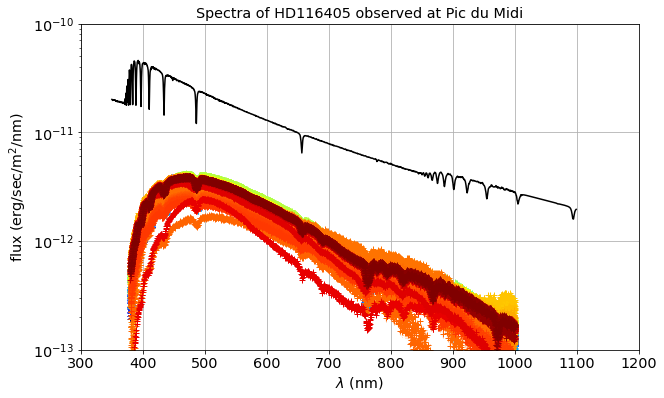

In [113]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=all_df[ifile]

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '+', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(1e-13,1e-10)
ax.set_yscale("log")

(25.0, 35.0)

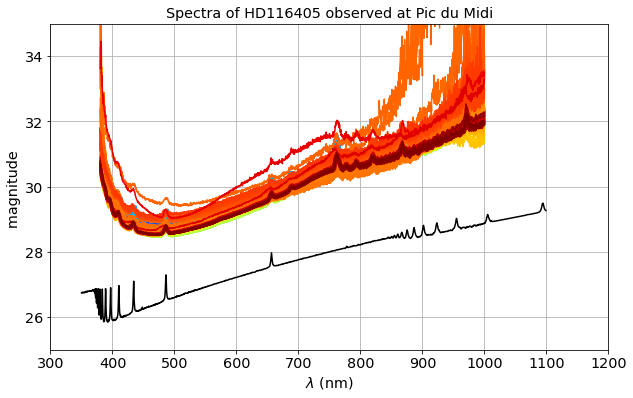

In [115]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=the_df=all_df[ifile]

    ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(25,35)

In [116]:
all_df[0].airmass[0]

1.545960928536013

# Convert Not filtered spectra into Mag table

In [117]:
WL,Mags,AirM,Tim = ConvertToImage(all_df,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

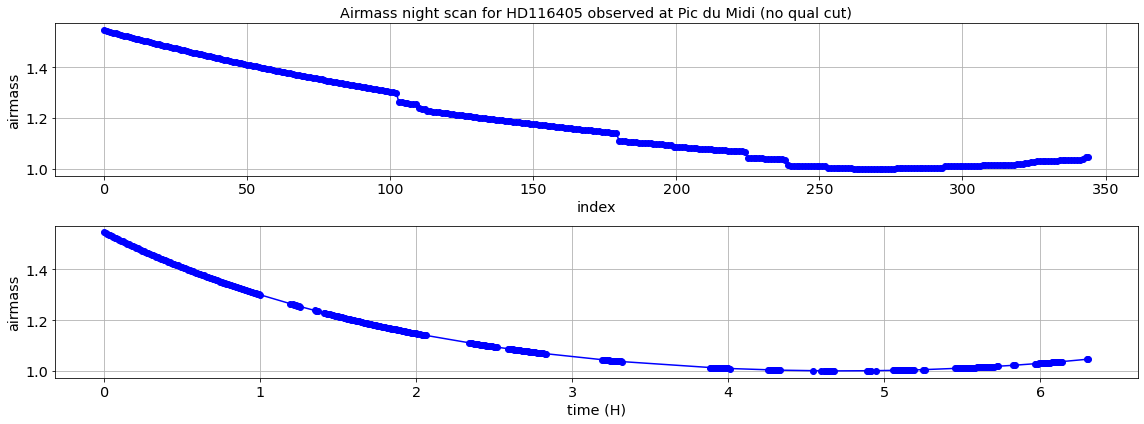

In [118]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Pic du Midi (no qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()

plt.tight_layout()


In [119]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [120]:
MagsRef=Mags-sed_mag0

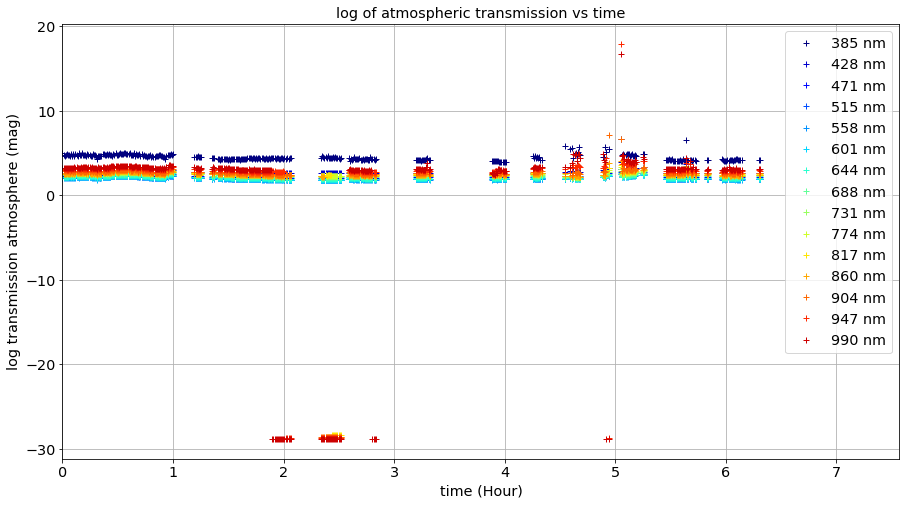

In [121]:
GetBouguerLinesTim(15,WL,Tim,MagsRef,FLAG_PLOT=True)

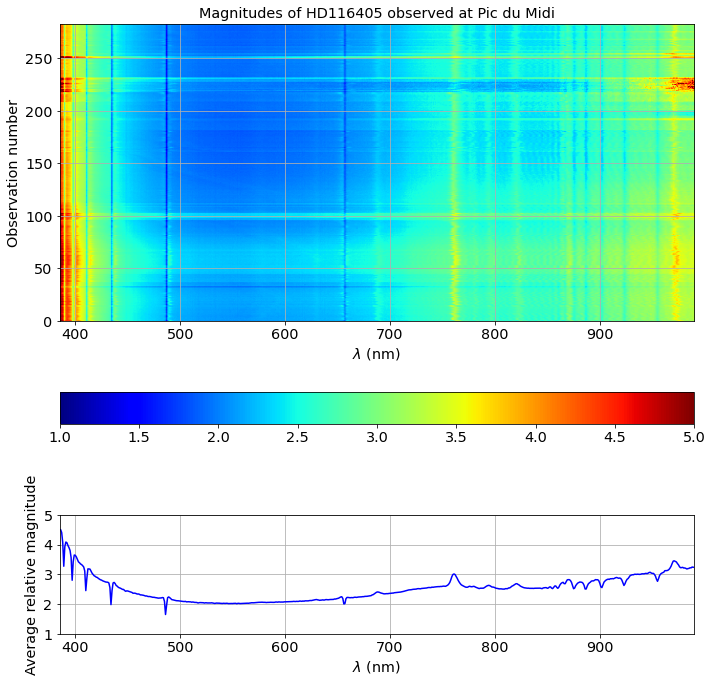

In [151]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBFILES)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Pic du Midi"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(1,5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

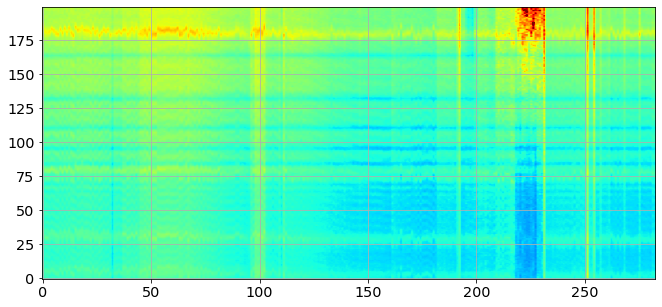

In [152]:
fig=plt.figure(figsize=(11,5))
ax=fig.add_subplot(111)
ax.imshow(MagsRef[:,-200:].T,origin="lower",norm=norm,cmap="jet",aspect="auto")
ax.grid()

In [124]:
profileY=np.average(MagsRef[:,-200:],axis=1)

In [125]:
import mpld3
from mpld3 import plugins

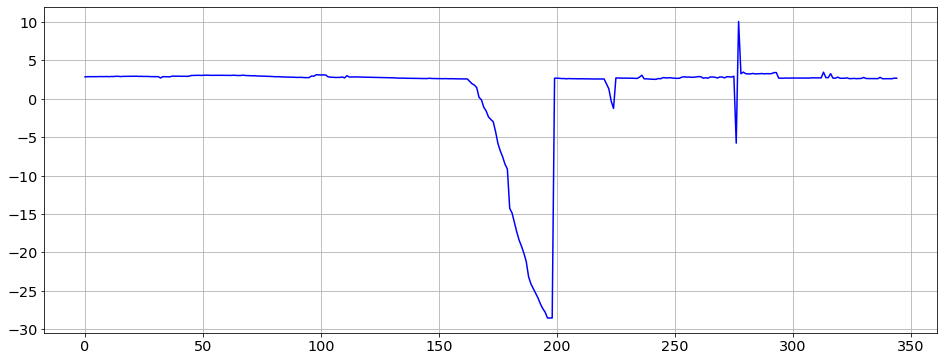

In [126]:
fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
ax.plot(profileY,'b')
ax.grid()

if 0:
    plugins.connect(fig, plugins.MousePosition(fontsize=14))
    mpld3.show()

# Filtered spectra

In [127]:
all_df_filt=GetSpectraFiltered(inputdir,selected_files,normalisation_factor=normalisation_factor)

In [128]:
all_df_filt[0].head()

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs
0,0,1.545961,0.0,380.067586,1.906583e-13,4.487186e-15,31.799361,0.023535,28.776280,0.023535
1,0,1.545961,0.0,380.511009,2.082932e-13,4.521747e-15,31.703312,0.021709,28.682771,0.021709
2,0,1.545961,0.0,380.954428,2.098480e-13,4.562320e-15,31.695238,0.021741,28.677220,0.021741
3,0,1.545961,0.0,381.397842,2.313665e-13,4.529898e-15,31.589249,0.019579,28.573740,0.019579
4,0,1.545961,0.0,381.841250,2.601964e-13,4.679267e-15,31.461747,0.017984,28.448731,0.017984


# Convert Not filtered spectra into Mag table

In [129]:
NBFILES=len(all_df_filt)

In [130]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

In [131]:
msg=f" Number of good spectra is {NBFILES}"
logger.info(msg)

2020-09-28 14:06:16,242 MacBook-Pro-de-admin.local __main__[25763] INFO  Number of good spectra is 283


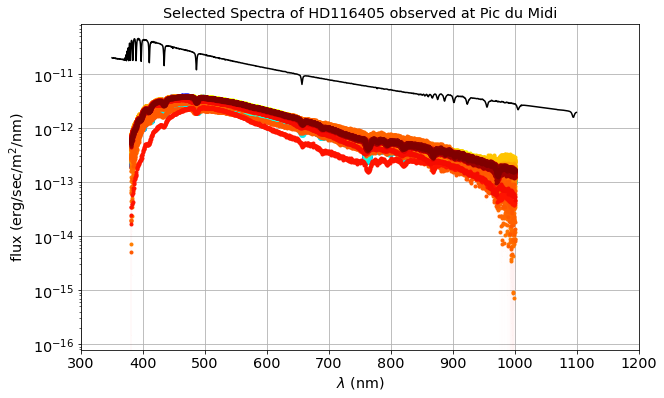

In [159]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=all_df_filt[ifile]

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_yscale("log")

(25.0, 35.0)

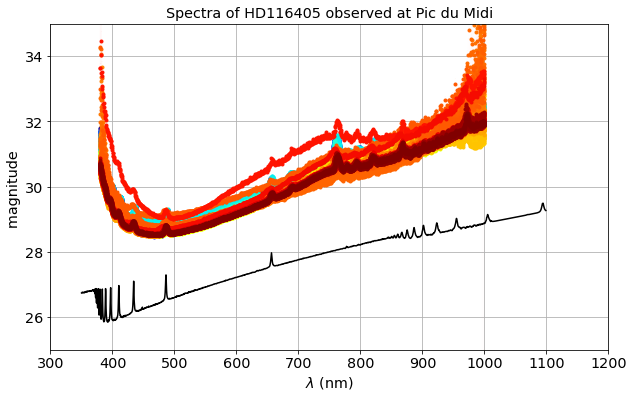

In [158]:
fig=plt.figure()
ax=fig.add_subplot(111)
for ifile in np.arange(NBFILES):
    the_df=the_df=all_df_filt[ifile]

    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    ax.errorbar(the_df.wavelength,the_df.mag,yerr=the_df.errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(25,35)

## Convert to image

In [134]:
WL,Mags, AirM,Tim = ConvertToImage(all_df_filt,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

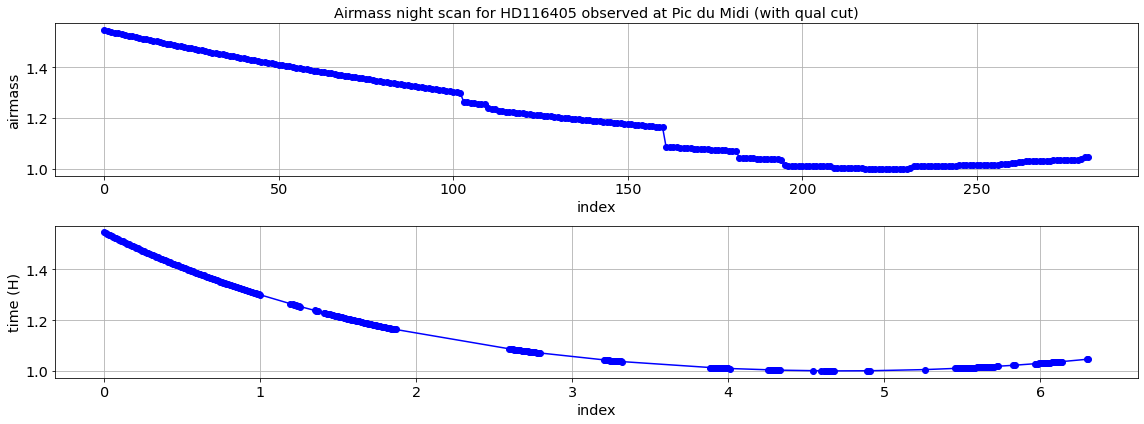

In [135]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Pic du Midi (with qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

In [136]:
MagsRef=Mags-sed_mag0

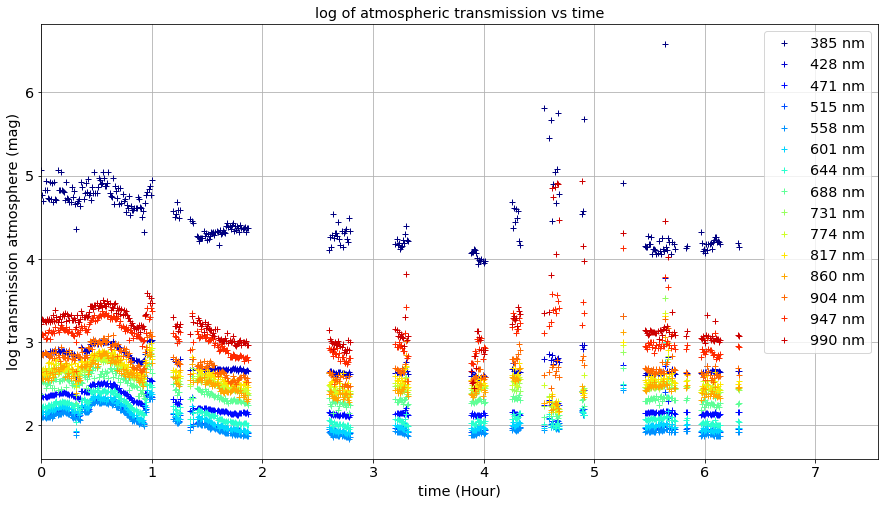

In [137]:
GetBouguerLinesTim(15,WL,Tim,MagsRef,FLAG_PLOT=True)

# Quality selection of observations

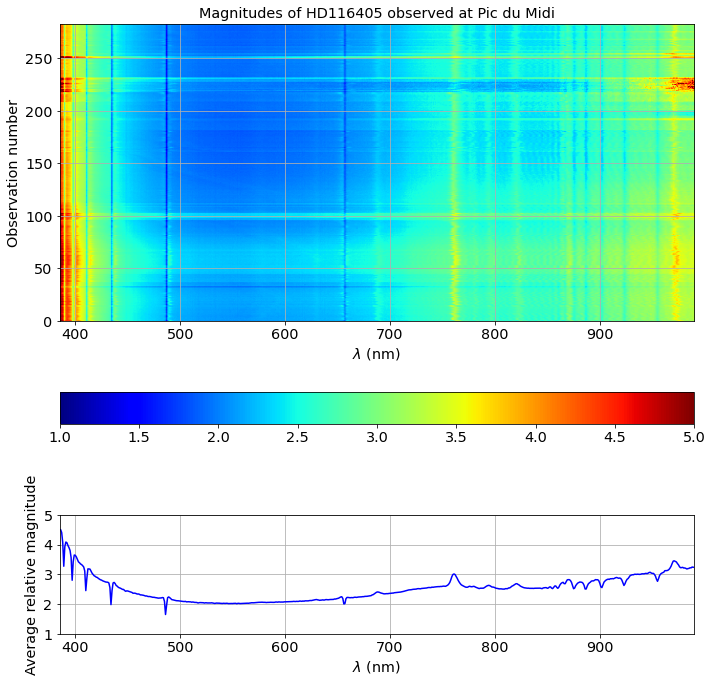

In [161]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBFILES)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Pic du Midi"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef,axis=0)
ax2.plot(WL,Y,"b-")
ax2.set_ylim(1,5)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Bouguer line

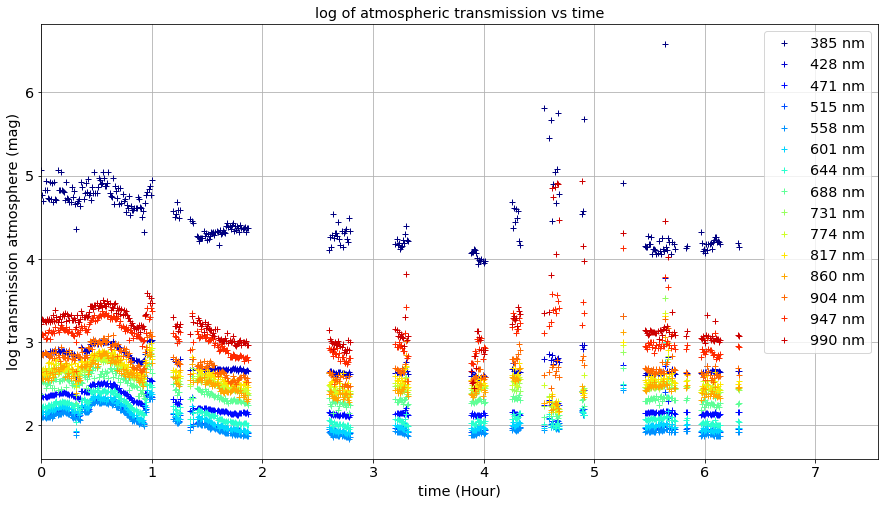

In [139]:
GetBouguerLinesTim(15,WL,Tim,MagsRef,FLAG_PLOT=True)

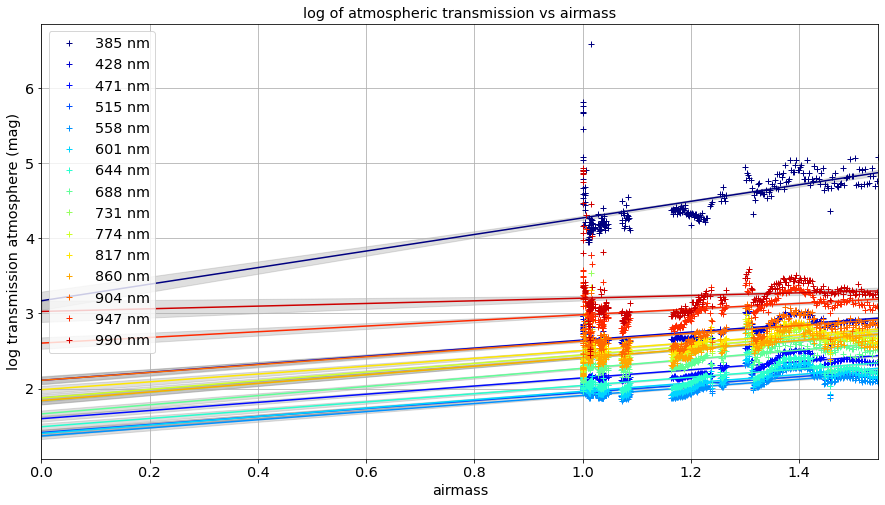

In [140]:
w,m,e=GetBouguerLinesAtm(15,WL,AirM,MagsRef,FLAG_PLOT=True)

In [141]:
w_s,m_s,em_s=GetBouguerLinesAtm(100,WL,AirM,MagsRef,FLAG_PLOT=False)

In [142]:
transm_s=np.power(10,-m_s/2.5)
etransm_s=em_s*transm_s

In [143]:
factor=1.0 # suppose Spectractor has divided the flux by Ronchi efficiency
transm_s=transm_s*factor
etransm_s=etransm_s*factor

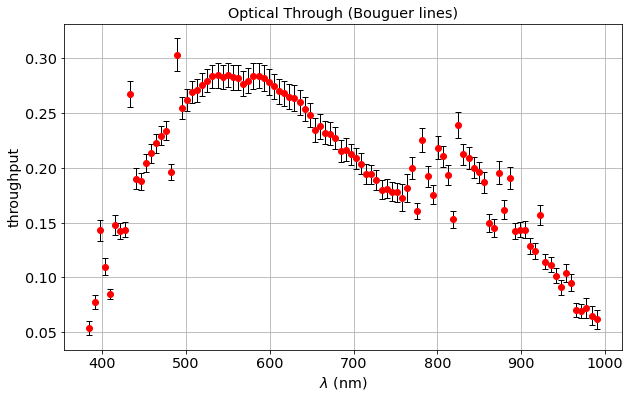

In [144]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(w_s,transm_s,yerr=etransm_s,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1)
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Optical Through (Bouguer lines)"
ax.set_title(title)
ax.grid()